# 1. Installing required packages

OpenAI Gym

In [1]:
# !pip install gym

PyTorch

In [2]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Protobuf

In [3]:
# !pip install stable-baselines3[extra] protobuf==3.20.*

To detect the GAME OVER

In [4]:
# !pip install mss pydirectinput pytesseract

In [47]:
#chrome://dino/

In [48]:
# screen capture
from mss import mss

# commands
import pydirectinput

import cv2
import numpy as np

# GAME OVER extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'


from matplotlib import pyplot as plt
import time

# Env components (OpenAI Gym)
import gym
from gym import Env
from gym.spaces import Box, Discrete

tesseract issue: https://github.com/tesseract-ocr/tesseract/issues/1799

# 2. Build custom environment
## 2.1 Create environment

In [184]:
class WebGame(gym.Env):
    # Setup env, action, and observation shapes
    def __init__(self):
        super().__init__()
        
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,50,100), dtype=np.uint8) # screen give
        self.action_space = Discrete(3) # 3 actions
        
        # Capture game frames
        self.cap = mss()
        
        # Pixel values for the required observations
        self.game_location = {'top': 1300, 'left': 100, 'width': 1000, 'height': 500}
        self.done_location = {'top': 1200, 'left': 1200, 'width': 1500, 'height': 140}
    
    # Doing something in the game
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        # If action input required
        if action !=2:
            pydirectinput.press(action_map[action])
            
        # Check if game is done
        done, done_cap = self.get_done()
        
        # Get new observation
        observation = self.get_observation()
        
        # Rewarding agent (can change to make it more complex)
        reward = 1
        info = {}
        return observation, reward, done, info
        
    # Visualize game
    # Needs fixing
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    
    # Restart game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
    
    # Closes the observation
    def close(self):
        pass
    # Get output of game
    def get_observation(self):
        # Get screen capture
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,50))
        channel = np.reshape(resized, (1,50,100))
        return channel
    
    # Get done text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

## 2.2 Test environment creation

In [185]:
env = WebGame()

In [186]:
obs=env.get_observation()

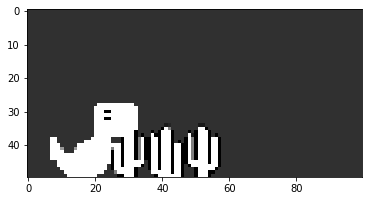

In [187]:
plt.imshow(obs[0], cmap='gray')

In [188]:
done, done_cap = env.get_done()
done

True

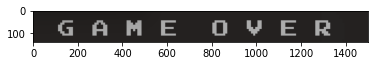

In [189]:
plt.imshow(done_cap, cmap='gray')

In [190]:
# for episode in range(10): 
#     obs = env.reset()
#     done = False  
#     total_reward = 0
#     while not done: 
#         obs, reward, done,info = env.step(env.action_space.sample())
#         total_reward += reward
#     print('Total Reward for episode {} is {}'.format(episode, total_reward))   

# 3. Train a model
## 3.1 Create callback

In [191]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [192]:
# env_checker.check_env(env)

In [193]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [194]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [195]:
callback = TrainAndLoggingCallback(check_freq=500, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [196]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [197]:
env = WebGame()

In [198]:
# Create DQN model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=400000, learning_starts=500)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\ayaan\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# TRAINING
model.learn(total_timesteps=20000, callback=callback)

Logging to ./logs/DQN_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.75     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 13       |
|    total_timesteps  | 11       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.62     |
|    ep_rew_mean      | 5.62     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 39       |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.58     |
|    ep_rew_mean      | 8.58     |
|    exploration_rate | 0.951    |
| time/               |        

In [199]:
model.load('train/best_model_3500') 

# 4. Testing model

In [34]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 9
Total Reward for episode 1 is 10
Total Reward for episode 2 is 10
Total Reward for episode 3 is 10
Total Reward for episode 4 is 10
